# Greg

# James

# Han

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline
import regex as re
from zipfile import ZipFile
import seaborn as sns

In [2]:
movieinfoDF = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')

In [3]:
movieinfoDF

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [4]:
tmdbMoviesDF = pd.read_csv('zippedData/tmdb.movies.csv.gz')

In [5]:
tmdbMoviesDF.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [6]:
movieBudgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')


In [7]:
movieBudgets.tail()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
5781,82,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


In [8]:
movieBudgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [9]:
bomgrossDF = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

In [10]:
bomgrossDF.tail()

,title,studio,domestic_gross,foreign_gross,year
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018
3386,An Actor Prepares,Grav.,1700.0,NaN,2018


In [11]:
rot_tomatoes_reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", sep='\t',
                                   encoding= 'unicode_escape')

In [12]:
rot_tomatoes_reviews.tail()

,id,review,rating,fresh,critic,top_critic,publisher,date
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"
54431,2000,NaN,3/5,fresh,Nicolas Lacroix,0,Showbizz.net,"November 12, 2002"


In [13]:
file_name = "./zippedData/im.db.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    #zip.printdir()
    zip.extractall()

In [14]:
conn = sqlite3.connect('./im.db')

In [15]:
pd.read_sql('''
SELECT *
FROM movie_basics;
''',conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [16]:
pd.read_sql('''
SELECT *
FROM movie_ratings;
''',conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [17]:
pd.read_sql("""SELECT movie_id, averagerating
                FROM movie_ratings;
                """,conn)

,movie_id,averagerating
0,tt10356526,8.3
1,tt10384606,8.9
2,tt1042974,6.4
3,tt1043726,4.2
4,tt1060240,6.5
...,...,...
73851,tt9805820,8.1
73852,tt9844256,7.5
73853,tt9851050,4.7
73854,tt9886934,7.0


In [18]:
#joining the move basics and ratings tables
joinedtables = pd.read_sql("""SELECT movie_basics.movie_id, movie_ratings.averagerating, movie_basics.genres, movie_basics.primary_title
FROM movie_basics
JOIN movie_ratings ON movie_basics.movie_id=movie_ratings.movie_id
ORDER BY averagerating DESC;
""", conn)

In [19]:
joinedtables

,movie_id,averagerating,genres,primary_title
0,tt10176328,10.0,Documentary,Exteriores: Mulheres Brasileiras na Diplomacia
1,tt10378660,10.0,"Comedy,Drama",The Dark Knight: The Ballad of the N Word
2,tt1770682,10.0,"Crime,Documentary",Freeing Bernie Baran
3,tt2632430,10.0,Documentary,Hercule contre Hermès
4,tt4109192,10.0,Documentary,I Was Born Yesterday!
...,...,...,...,...
73851,tt8446392,1.0,Drama,La Scelta Impossibile
73852,tt8654080,1.0,Horror,Overdose of Gore: Crime born Crime
73853,tt9005484,1.0,Drama,Roofied: The Lethal Dose
73854,tt9352262,1.0,Drama,The Defender


In [20]:
#top 10
top10 = joinedtables.head(10)

In [21]:
#bottom 10
bot10 = joinedtables.tail(10)

In [22]:
#show top 10 rated movies
top10

,movie_id,averagerating,genres,primary_title
0,tt10176328,10.0,Documentary,Exteriores: Mulheres Brasileiras na Diplomacia
1,tt10378660,10.0,"Comedy,Drama",The Dark Knight: The Ballad of the N Word
2,tt1770682,10.0,"Crime,Documentary",Freeing Bernie Baran
3,tt2632430,10.0,Documentary,Hercule contre Hermès
4,tt4109192,10.0,Documentary,I Was Born Yesterday!
5,tt4944240,10.0,Drama,Dog Days in the Heartland
6,tt4960818,10.0,Documentary,Revolution Food
7,tt5089804,10.0,Documentary,Fly High: Story of the Disc Dog
8,tt5344358,10.0,Documentary,All Around Us
9,tt5390098,10.0,Documentary,The Paternal Bond: Barbary Macaques


In [23]:
#show bottom 10 rated movies
bot10

,movie_id,averagerating,genres,primary_title
73846,tt7923374,1.0,"Comedy,Fantasy",Badang
73847,tt7926296,1.0,Drama,Nakhodka interneta
73848,tt8176282,1.0,Documentary,Des figues en avril
73849,tt8313262,1.0,Drama,Glaza i mir. Chast 1
73850,tt8426154,1.0,Animation,Pup Scouts
73851,tt8446392,1.0,Drama,La Scelta Impossibile
73852,tt8654080,1.0,Horror,Overdose of Gore: Crime born Crime
73853,tt9005484,1.0,Drama,Roofied: The Lethal Dose
73854,tt9352262,1.0,Drama,The Defender
73855,tt9378134,1.0,"Comedy,Drama",Startup Girls


In [24]:
#drop null values from the table
clean_table = joinedtables.dropna()

In [25]:
the_numbers = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
the_numbers.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [26]:
def z_score(value, mean, std):
    return (value - mean) / std

In [27]:
def make_int(string):
    return int(string.replace("$","").replace(",",""))

In [28]:
the_numbers['production_budget'] = the_numbers['production_budget'].apply(lambda x: make_int(x))
the_numbers['domestic_gross'] = the_numbers['domestic_gross'].apply(lambda x: make_int(x))
the_numbers['worldwide_gross'] = the_numbers['worldwide_gross'].apply(lambda x: make_int(x))

In [29]:
the_numbers_mean = the_numbers['worldwide_gross'].mean()
the_numbers_med = the_numbers['worldwide_gross'].median()
the_numbers_std = the_numbers['worldwide_gross'].std()

print(the_numbers_mean)
print(the_numbers_med)

the_numbers['z_score'] = the_numbers['worldwide_gross'].apply(lambda x: z_score(x, the_numbers_mean, the_numbers_std))

91487460.90643376
27984448.5


In [30]:
gross_outliers = the_numbers[the_numbers['z_score'] > 3]
outliers_movies_lst = list(gross_outliers['movie'].values)
outliers_movies_lst

['Avatar',
 'Pirates of the Caribbean: On Stranger Tides',
 'Avengers: Age of Ultron',
 'Star Wars Ep. VIII: The Last Jedi',
 'Star Wars Ep. VII: The Force Awakens',
 'Avengers: Infinity War',
 'Pirates of the Caribbean: At Worldâ\x80\x99s End',
 'Justice League',
 'Spectre',
 'The Dark Knight Rises',
 'Spider-Man 3',
 'Captain America: Civil War',
 'Batman v Superman: Dawn of Justice',
 'The Hobbit: An Unexpected Journey',
 'Harry Potter and the Half-Blood Prince',
 'The Hobbit: The Desolation of Smaug',
 'The Hobbit: The Battle of the Five Armies',
 'The Fate of the Furious',
 'Pirates of the Caribbean: Dead Men Tell No Tales',
 'The Avengers',
 'Pirates of the Caribbean: Dead Manâ\x80\x99s Chest',
 'Man of Steel',
 'The Amazing Spider-Man',
 'Jurassic World',
 'Men in Black 3',
 'Transformers: Revenge of the Fallen',
 'Transformers: Age of Extinction',
 'Black Panther',
 'Titanic',
 'Incredibles 2',
 'Rogue One: A Star Wars Story',
 'Finding Dory',
 'Toy Story 3',
 'Iron Man 3',
 'G

In [31]:
imdb = pd.read_sql(f"""
SELECT pr.person_id, primary_name, death_year, category, primary_title,
       original_title
FROM persons p
LEFT JOIN principals pr ON pr.person_id = p.person_id
LEFT JOIN movie_basics mb ON pr.movie_id = mb.movie_id
""", conn)

In [32]:
imdb = imdb[imdb['death_year'].isnull() == True]
imdb_outliers = imdb[imdb['primary_title'].isin(outliers_movies_lst)]
display(imdb_outliers)
grouped = imdb_outliers.groupby(['category','primary_name']).size().reset_index(name='counts')
grouped2 = grouped[grouped['counts'] > 2]

,person_id,primary_name,death_year,category,primary_title,original_title
480,nm0125336,Jez Butterworth,NaN,writer,Spectre,Spectre
2286,nm0671567,Michael Peña,NaN,actor,Ant-Man and the Wasp,Ant-Man and the Wasp
2797,nm0834902,Robert Stromberg,NaN,director,Maleficent,Maleficent
2799,nm0837112,Richard Suckle,NaN,producer,Suicide Squad,Suicide Squad
3273,nm1014201,Rhett Reese,NaN,writer,Deadpool,Deadpool
...,...,...,...,...,...,...
1005549,nm9989238,Suneet Gautam,NaN,composer,Titanic,Titanic
1009487,nm9989231,Mahesh Vashisht,NaN,composer,Titanic,Titanic
1013926,nm9039216,Neil Boultby,NaN,actor,Coco,Coco
1029087,nm9061881,Natalia Kaverznikova,NaN,actress,Coco,Coco


In [33]:
#show table of actors that appear more than 2 times.
grouped2

,category,primary_name,counts
30,actor,Chris Evans,5
31,actor,Chris Hemsworth,4
33,actor,Chris Pratt,3
49,actor,Dwayne Johnson,5
74,actor,Ian McKellen,4
99,actor,Johnny Depp,4
106,actor,Josh Hutcherson,4
119,actor,Liam Hemsworth,4
124,actor,Mark Ruffalo,3
126,actor,Martin Freeman,3


In [65]:
#creates a df that shows actors appearances more than 3 times.
grouped3 = grouped[grouped['counts'] > 3]

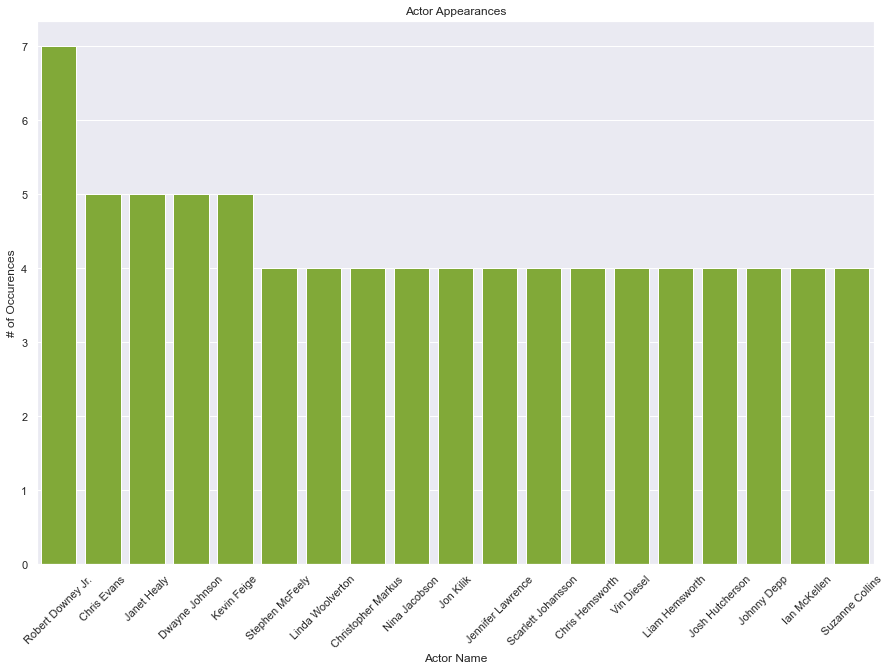

In [72]:
#plot actors that occur 4 or more times.
ax = sns.barplot(x="primary_name", y="counts", data=grouped3, color="#86BC25", order=grouped3.sort_values('counts', ascending=False).primary_name)
sns.set(rc={'figure.figsize':(15,10)})
ax.set_title("Actor Appearances")
ax.set_xlabel("Actor Name")
ax.set_ylabel("# of Occurences")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

plt.show()

# Rachel

# Himansri